# Case Study - Multiple testing

### Learning objective

|                                                                     | 
|:--------------------------------------------------------------------|
| Explain methods for dealing with multiple testing                   |

## Synopsis

The management team at AAVAIL is preparing to deploy a large number of teams each tasked with integration into a different new market.  They claim to have a optimized the teams fairly with respect to skills and experience.  They are asking you to come up with a framework to evaluate the makeup of their teams.  They have not finished hiring and creating all of the teams so naturally before you even get the data you wanted to get a head start.

Getting a head start usually involves finding a similar dataset and writing the code in a way that the new data, once obtained can be added with little effort.

When we perform a large number of statistical tests, some will have $p$-values less than the designated level of $\alpha$ (e.g. 0.05) purely by chance, even if all the null hypotheses are really true.  This is an inherent risk of using inferrential statistics.  Fortunately, there are several techniques to mitigate the risk.

We are going to look at the 2018 world cup data in this example.  

The case study is comprised of the following sections:

1. Data Cleaning
2. Data Visualization
3. NHT
4. Adjust NHT results for multiple comparisons

Data science work that focuses on creating a predictive model is perhaps the hallmark of the field today, but there are still many use cases where [inferential statistics](https://en.wikipedia.org/wiki/Statistical_inference) are the best tool available. One issue with statistical inference is that there are situations where [performing multiple tests](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) is a  logical way to accomplish a task, but it comes at the expense of an increased rate of false positives or Type I errors.

In this case study you will apply techniques and knowledge from all of the units in Module 2.

## Getting started

**This unit is interactive**.  During this unit we encourage you to [open this file as a notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest).  Download the notebook from the following link then open it locally using a Jupyter server or use your IBM cloud account to login to Watson Studio.  Inside of Waston Studio cloud if you have not already ensure that this notebook is loaded as part of the *project* for this course. As a reminder fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***.  The data and notebook for this unit are available below.

* [m2-u7-case-study.ipynb](m2-u7-case-study.ipynb)
* [worldcup-2018.csv](./data/worldcup-2018.csv)

This unit is organized into the following sections:

1. Data Processing
2. Data Summary
3. Investigative Visualization
4. Hypothesis testing

#### Resources

* [Creating or uploading a notebook in IBM cloud](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/creating-notebooks.html)
* [Resources for multiple testing in Python](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html)

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## Import the Data

Before we jump into the data it can be useful to give a little background so that you can better understand the features.  Since the dawn of statistics practitioners have been trying to find advantages when it comes to games.  Much of this was motivated by gambling---here we will look at the results from this tournament in a different way.  We are going to ask the simple question

  >Was the tournament setup in a fair way?

Of course the findings from an investigation centering around this question could be used to strategically place bets, but lets assume that we are simply interested in whether or not the tournament organizers did an adequate job.  The reason for doing this is to prepare for the AAVAIL data that is coming.  This exercise is an important reminder that you do not have to wait until the day that data arrive to start your work. 

There are 32 teams, each representing a single country, that compete in groups or pools then the best teams from those groups compete in a single elimination tournament to see who will become world champions.  This is by far the world's most popular sport so one would hope that the governing organization FIFA did a good job composing the pools.  If for example there are 8 highly ranked teams then each of those teams should be in a different pool. 

In our data set we have more than just rank so we can dig in a little deeper than that, but first let's have a look at the data.

In [2]:
DATA_DIR = os.path.join(".","data")
df = pd.read_csv(os.path.join(DATA_DIR, 'worldcup-2018.csv'))
df.columns = [re.sub("\s+","_",col.lower()) for col in df.columns]
df.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,first_match_against,match_index,history_with_first_opponent_w-l,history_with_first_opponent_goals,second_match_against,match_index.1,history_with_second_opponent_w-l,history_with_second_opponent_goals,third_match_against,match_index.2,history_with_third_opponent_w-l,history_with_third_opponent_goals,unnamed:_19
0,Russia,A,10,0,0,1,65,Saudi Arabia,1,-1.0,-2.0,Egypt,17,NaN,NaN,Uruguay,33,0.0,0.0,NaN
1,Saudi Arabia,A,4,0,0,0,63,Russia,1,1.0,2.0,Uruguay,18,1.0,1.0,Egypt,34,-5.0,-5.0,NaN
2,Egypt,A,2,0,0,0,31,Uruguay,2,-1.0,-2.0,Russia,17,NaN,NaN,Saudi Arabia,34,5.0,5.0,NaN
3,Uruguay,A,12,2,2,5,21,Egypt,2,1.0,2.0,Saudi Arabia,18,-1.0,-1.0,Russia,33,0.0,0.0,NaN
4,Porugal,B,6,0,0,2,3,Spain,3,-12.0,-31.0,Morocco,19,-1.0,-2.0,Iran,35,2.0,5.0,NaN


To limit the dataset for educational purposes we create a new data frame that consists of only the following columns: 

* team
* group
* previous_appearances
* previous_titles
* previous_finals
* previous_semifinals
* current_fifa_rank

## Data Processing

### QUESTION 1

Using the column names below create a new dataframe that uses only them.

In [3]:
columns = ['team', 'group','previous_appearances','previous_titles','previous_finals',
           'previous_semifinals','current_fifa_rank']

### YOUR CODE HERE
df_new = df[columns]
df_new.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank
0,Russia,A,10,0,0,1,65
1,Saudi Arabia,A,4,0,0,0,63
2,Egypt,A,2,0,0,0,31
3,Uruguay,A,12,2,2,5,21
4,Porugal,B,6,0,0,2,3


To help with this analysis we are going to engineer a feature that combines all of the data in the table.  This feature represents the past performance of a team.  Given the data we have it is the best proxy on hand for how good a team will perfom.  Feel free to change the multiplers, but let's just say that `past_performance` will be a linear combination of the related features we have.

Let $X_{1}$,...,$X_{4}$ be `previous_titles`,`previous_finals`,`previous_semifinals`,`previous_appearances` and let the corresponding vector $\mathbf{\alpha}$ be the multipliers.  This will give us,

$$
\textrm{past_performance} = \alpha_{1} X_{1} + \alpha_{2} X_{2} + \alpha_{3} X_{3} + \alpha_{4} X_{4}
$$

Modify $\mathbf{\alpha}$ if you wish.  Then add to your dataframe the new feature `past_performance`.

### QUESTION 2

create the engineered feature as a new column

In [4]:
alpha = np.array([16,8,4,1])

### YOUR CODE HERE
pd.options.mode.chained_assignment = None

x_cols = ['previous_titles', 'previous_finals', 'previous_semifinals', 'previous_appearances']
df_new['past_performance'] = df_new[x_cols].dot(alpha)

df_new.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
0,Russia,A,10,0,0,1,65,14
1,Saudi Arabia,A,4,0,0,0,63,4
2,Egypt,A,2,0,0,0,31,2
3,Uruguay,A,12,2,2,5,21,80
4,Porugal,B,6,0,0,2,3,14


## Data Summary

### QUESTION 3

Using your choice of tools create one or more **tabular summaries** of the data

In [15]:
df_new.groupby(['group'])['current_fifa_rank', 'past_performance'].mean()

,current_fifa_rank,past_performance
group,,
A,45.00,25.00
B,20.25,17.00
C,17.75,19.50
D,23.25,30.25
E,18.25,58.25
F,23.50,65.25
G,25.75,16.50
H,24.50,6.50


In [125]:
print('Global means')
rank_perf = ['current_fifa_rank','past_performance']

df_new[rank_perf].mean()

Global means


current_fifa_rank    24.78125
past_performance     29.78125
dtype: float64

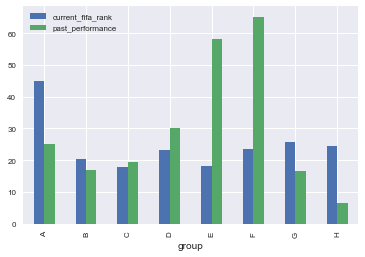

In [11]:
df_new.groupby(['group'])['current_fifa_rank', 'past_performance'].mean().plot(kind='bar')

In [39]:
df_new.groupby(['group']).agg({'current_fifa_rank':['min','max','mean','std'],
                               'past_performance': ['min','max','mean','std']})

current_fifa_rank                       past_performance              \
                    min max   mean        std              min  max   mean   
group                                                                        
A                    21  65  45.00  22.330846                2   80  25.00   
B                     3  40  20.25  18.518009                4   46  17.00   
C                     9  39  17.75  14.221463                4   66  19.50   
D                     4  50  23.25  19.379972                0  108  30.25   
E                     2  37  18.25  16.132266                4  200  58.25   
F                     1  59  23.50  24.852901               13  198  65.25   
G                     5  56  25.75  22.081289                0   46  16.50   
H                     7  55  24.50  21.377558                1   15   6.50   

                  
             std  
group             
A      37.040518  
B      19.899749  
C      31.000000  
D      51.938265  
E      94.700845  
F      89.055694  
G      20.808652  
H       5.972158

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c36efd0>,
      dtype=object)

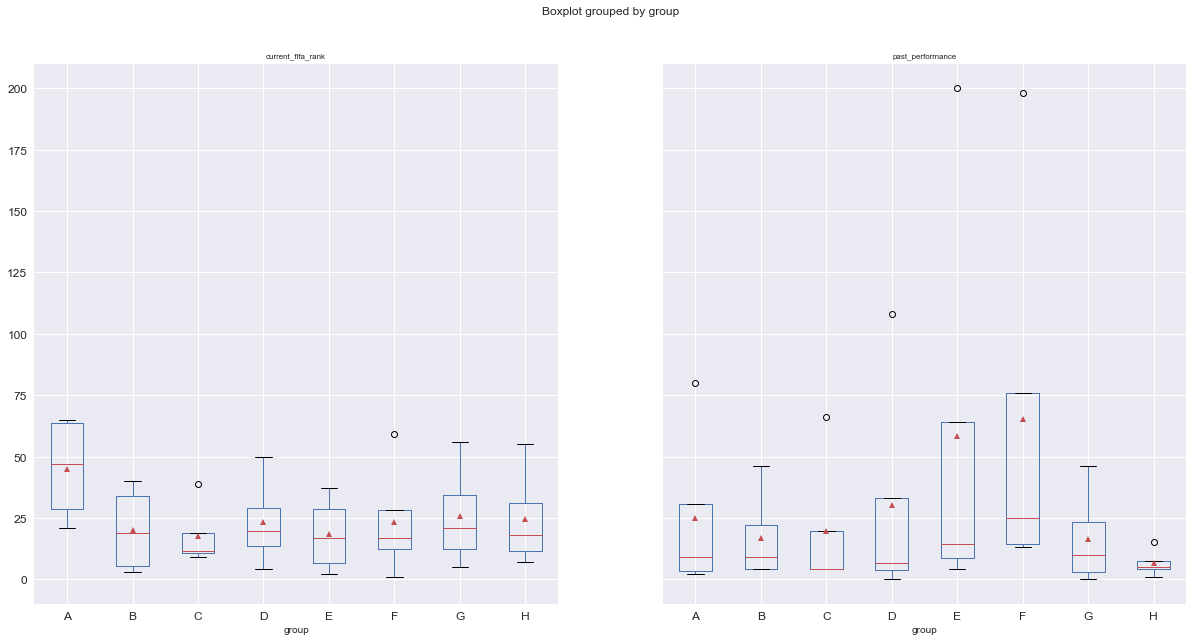

In [77]:
rank_perf = ['current_fifa_rank','past_performance']
df_new.boxplot(column=rank_perf, by='group', figsize=(20,10), fontsize='12', showmeans=True)

### QUESTION 4

Check for missing data. Write code to identify if there is any missing data.

In [196]:
### YOUR CODE HERE
df_new.isnull().any(axis=1).any()

False

## Investigative Visualization

### QUESTION 5

Come up with one or more plots that investigate the central question... Are the groups comprised in a fair way?


See above

## Hypothesis Testing

There are a number of ways to use hypothesis testing in this situation.  There are certainly reasonable hypotheses tests and other methods like simulation approaches, that we have not discussed, but they would be appropriate here.  If you choose to explore some of the methods that are outside the scope of this course then we encourage you to first try the simple approach proposed here and compare the results to any further additional approaches you choose to use.

We could use an ANOVA approach here that would signify a difference between groups, but we would not know which and how many teams were different.  As we stated before there are a number of ways to approach the investigation, but lets use a simple approach.  We are going to setup our investigation to look at all pairwise comparisons to provide as much insight as possible.

Recall that there are $\frac{(N-1)(N)}{2}$ pairwise comparisons.

In [86]:
N = np.unique(df['group'].values).size
print("num comparisons: ",((N-1)*N) / 2.0)

num comparisons:  28.0


### QUESTION 5


1. Choose a hypothesis test
2. State the null and alternative hypothesis, and choose a cutoff value $\alpha$
3. Run the test for all pairwise comparisons between teams

YOUR ANSWER HERE

Let's start with a simple one-way ANOVA test. 

Null hypothesis in this case is that all groups have the same population mean. Set α=0.05. 

CAUTION: We note that ANOVA assumes all groups have same std, but we see from box plot this isn't true.

In [157]:
groupby = df_new.groupby(['group'])
data = [d[['past_performance']] for groupname, d in groupby]

data

f, p = stats.f_oneway(*data)

print("past performance p-value: {}".format(round(p[0],5)))

past performance p-value: 0.73618


Now onto pairwise comparisons. Same H-zero and alpha.

In [199]:
from itertools import combinations

grouped = df_new.groupby('group')

df_stats = pd.DataFrame()

print('Two-sample independent t-test, unequal variances')
print('----------------------------------------------')

for i, pair in enumerate(combinations(grouped, 2)):    
    s, p = stats.ttest_ind(pair[0][1]['past_performance'], pair[1][1]['past_performance'], equal_var=False)
    print(f'{pair[0][0]} x {pair[1][0]}   :   p = {p:.4f}')

Two-sample independent t-test, unequal variances
----------------------------------------------
A x B   :   p = 0.7205
A x C   :   p = 0.8276
A x D   :   p = 0.8752
A x E   :   p = 0.5497
A x F   :   p = 0.4508
A x G   :   p = 0.7065
A x H   :   p = 0.3935
B x C   :   p = 0.8972
B x D   :   p = 0.6595
B x E   :   p = 0.4519
B x F   :   p = 0.3615
B x G   :   p = 0.9734
B x H   :   p = 0.3762
C x D   :   p = 0.7370
C x E   :   p = 0.4842
C x F   :   p = 0.3907
C x G   :   p = 0.8783
C x H   :   p = 0.4667
D x E   :   p = 0.6278
D x F   :   p = 0.5283
D x G   :   p = 0.6492
D x H   :   p = 0.4290
E x F   :   p = 0.9178
E x G   :   p = 0.4474
E x H   :   p = 0.3546
F x G   :   p = 0.3576
F x H   :   p = 0.2788
G x H   :   p = 0.4149


### QUESTION 6

For all of the $p$-values obtained apply the Bonferroni and at least one other correction for multiple hypothesis tests.  Then comment on the results.

In [229]:
from statsmodels.stats.multitest import multipletests

df_stats = pd.DataFrame()

pairs, pvals = zip(*[(f'{pair[0][0]}{pair[1][0]}', stats.ttest_ind(pair[0][1]['past_performance'], pair[1][1]['past_performance'], equal_var=False)[1]) for i, pair in enumerate(combinations(grouped, 2))])

df_stats['team pair'] = pairs
df_stats['p unadjusted'] = pvals

_results = multipletests(pvals, alpha = 0.05, method='bonferroni', is_sorted=False, returnsorted=False)
df_stats['p bonferroni']= _results[1]

_results = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
df_stats['p bh'] = _results[1]

df_stats

,team pair,p unadjusted,p bonferroni,p bh
0,AB,0.720495,1.0,0.938061
1,AC,0.827640,1.0,0.951753
2,AD,0.875223,1.0,0.951753
3,AE,0.549711,1.0,0.938061
4,AF,0.450795,1.0,0.938061
5,AG,0.706510,1.0,0.938061
6,AH,0.393493,1.0,0.938061
7,BC,0.897216,1.0,0.951753
8,BD,0.659453,1.0,0.938061
9,BE,0.451908,1.0,0.938061


Data suggests no evidence for rejecting the null hypothesis, i.e. that all groups have same mean past_performance. In other words no evidence that team distribution is fair.

NOTE: These results depend heavily on the weighting we used to determine the past_performance metric.

BUT: We needed to determine and be comfortable with this weighting before starting our analysis. To adjust it now would be P-HACKING.

## Additional Approaches 

There is an [allpairtest function in statsmodels](http://www.statsmodels.org/devel/generated/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest) that could be used here to combine the work from QUESTION 5 and QUESTION 6.

Generalized Linear Models (GLMs) are an appropriate tool to use here if we wanted to include the results of the tournament (maybe a ratio of wins/losses weighted by the final position in the tournament).  `statsmodels` supports [R-style formulas to fit generalized linear models](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html). One additional variant of GLMs are hierarchical or multilevel models that provide even more insight into this types of dataset.  See the [tutorial on multilevel modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html).